In [1]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-lg3r0mhw
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-lg3r0mhw
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=33212 sha256=558d5e879273612f5124750fcc63c2735be889a71883181318e8bd487974f8be
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-zuw9eare/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [13]:
def run_analysis(file, curve_idx, outdf, key):
    force_curve = file.getcurve(curve_idx)
    extend_segments = force_curve.extend_segments
    pause_segments = force_curve.pause_segments
    modulation_segments = force_curve.modulation_segments
    retract_segments = force_curve.retract_segments
    force_curve_segments = force_curve.get_segments()
    force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)
    # Get approach, first extend segment
    first_exted_seg_id, first_ext_seg = extend_segments[0]
    # Get retract, last retract segment
    last_ret_seg_id, last_ret_seg = retract_segments[-1]
    # Shift height
    force_curve.shift_height()
    v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    t_offset = np.abs(first_ext_seg.zheight[-1] - last_ret_seg.zheight[0]) / v0t
    dt = np.abs(first_ext_seg.time[1] - first_ext_seg.time[0])
    if t_offset > 2 * dt:
        last_ret_seg.time = last_ret_seg.time + t_offset
    app_height = first_ext_seg.zheight
    app_deflection = first_ext_seg.vdeflection
    ret_height = last_ret_seg.zheight
    ret_deflection = last_ret_seg.vdeflection
    # Find initial PoC, you may get some warnings.
    z = np.r_[app_height, ret_height]
    deltaz=np.abs(z.max()-z.min())
    zperpt=deltaz/len(z);
    win_size=int(windowforCP/2/zperpt)*2
    print(f'PoC Window Size --> {win_size}')
    rov_dfl_1 = pd.Series(app_deflection[win_size+1:])
    rov_dfl_2 = pd.Series(app_deflection[:-win_size])
    rovi = rov_dfl_1.rolling(win_size, center=True, min_periods=1).var(ddof=0)/\
           rov_dfl_2.rolling(win_size, center=True, min_periods=1).var(ddof=0)
    rovi_idx = np.argmax(rovi)
    # idxmaxRoVi = rovi_idx - win_size
    rov_poc = app_height[rovi_idx]
    poc = [rov_poc, 0]
    mask = app_height<rov_poc
    z = np.poly1d(np.polyfit(app_height[mask], app_deflection[mask], 1))
    app_deflection = app_deflection-z(app_height)
    ret_deflection = ret_deflection-z(ret_height)
    # Hertz fit
    first_ext_seg.get_force_vs_indentation(poc, spring_constant)
    app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

    # app_indentation = app_height - poc[0]
    # app_force = app_deflection*spring_constant
    fit_mask = app_indentation > (-1 * maxnoncontact)
    hertzmodel = HertzModel(indenter_shape, tip_parameter)
    hertzmodel.fit(app_indentation[fit_mask], app_force[fit_mask])

    # hertzmodel.fit_report()

    hertz_E0 = hertzmodel.E0
    hertz_d0 = hertzmodel.delta0
    hertz_F0 = hertzmodel.f0
    
    # Get force vs indentation for all segments
    poc[0] += hertz_d0

    # Get indentation and force
    first_ext_seg.get_force_vs_indentation(poc, spring_constant)
    app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
    last_ret_seg.get_force_vs_indentation(poc, spring_constant)
    ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time
    
    idx_tc = (np.abs(app_indentation - 0)).argmin()
    t0 = app_time[-1]
    indentation = np.r_[app_indentation, ret_indentation]
    time = np.r_[app_time, ret_time + t0]
    force = np.r_[app_force, ret_force]
    fit_mask = indentation > (-1 * maxnoncontact)
    tc = time[idx_tc]
    ind_fit = indentation[fit_mask]
    force_fit = force[fit_mask]
    force_fit = force_fit - force_fit[0]
    time_fit = time[fit_mask]
    tc_fit = tc-time_fit[0]
    time_fit = time_fit - time_fit[0] - tc_fit
    tm = time_fit[np.argmax(force_fit)]
    idx_tm = np.argmax(force_fit)
    
    downfactor=int(len(time_fit)/300)
    print(f'Downfactor --> {downfactor}')
    
    idxDown = list(range(0, len(time_fit), downfactor))
    idx_tm = np.argmax(force_fit[idxDown])
    f0idx = np.where(time_fit==tc_fit)[0]
    F0_init=force_fit[f0idx]
    
    plt.plot(time_fit[idxDown], force_fit[idxDown])
    plt.show()
    
    plt.plot(time_fit[idxDown], ind_fit[idxDown])
    plt.show()
    
    tc_max = tc_fit+downfactor/(1/(time_fit[1]-time_fit[0]))*10
    tc_min = tc_fit-downfactor/(1/(time_fit[1]-time_fit[0]))*10
    f0_max = F0_init+100e-12
    f0_min = F0_init-100e-12
    
    modelFt = 'analytical'
    ting_model_num = TingModel(indenter_shape, tip_parameter, modelFt)
    v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    idx_tm = np.argmax(force_fit[idxDown])
    model_for_fit = lambda time, E0, tc, betaE, F0: ting_model_num.model(time, E0, tc, betaE, F0, t0, force_fit[idxDown], ind_fit[idxDown], modelFt, vdrag, idx_tm, smooth_w, v0t, v0r)
    model = Model(model_for_fit)
    print(f'parameter names: {model.param_names}')
    print(f'independent variables: {model.independent_vars}')
    params = Parameters()
    params.add('E0', value=hertz_E0, min=hertz_E0/1000, max=np.inf)
    params.add('tc', value=0, min=tc_min, max=tc_max)
    params.add('betaE', value=0.25, min=0.01, max=0.49)
    params.add('F0', value=F0_init, min=f0_min, max=f0_max)

    result_J = model.fit(force_fit[idxDown], params, time=time_fit[idxDown])
    
    modelFt = 'numerical'
    v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    idx_tm = np.argmax(force_fit[idxDown])
    model_for_fit = lambda time, E0, tc, betaE, F0: ting_model_num.model(time, E0, tc, betaE, F0, t0, force_fit[idxDown], ind_fit[idxDown], modelFt, vdrag, idx_tm, smooth_w, v0t, v0r)
    model = Model(model_for_fit)
    print(f'parameter names: {model.param_names}')
    print(f'independent variables: {model.independent_vars}')
    params = Parameters()
    params.add('E0', value=hertz_E0, min=hertz_E0/1000, max=np.inf)
    params.add('tc', value=0, min=tc_min, max=tc_max)
    params.add('betaE', value=0.25, min=0.01, max=0.49)
    params.add('F0', value=F0_init, min=f0_min, max=f0_max)

    result_Tn = model.fit(force_fit[idxDown], params, time=time_fit[idxDown])
    
    # for param, value in result.best_values.items():
    #     print(f'{param}:{value}')
    
    # f0 = result.best_values['F0']
    
    fig, ax = plt.subplots()
    ax.plot(ind_fit[idxDown], force_fit[idxDown], 'o', label='raw data')
    ax.plot(ind_fit[idxDown], result_J.best_fit, '--', label='J best fit')
    ax.plot(ind_fit[idxDown], result_Tn.best_fit, '--', label='Tn best fit')
    ax.legend()
    fig.savefig(f"./{curve_idx}_{key}.png")
    
    filemetadata = file.filemetadata
    
    resdf = pd.DataFrame({
        'file_path': filemetadata.get('file_path'),
        'curve_idx': curve_idx,
        'PoC_window': windowforCP,
        'tip_shape': indenter_shape,
        'RoV_poc': rov_poc,
        'E0_hertz': hertz_E0,
        'd0_hertz': hertz_d0,
        'F0_hertz': hertz_F0,
        'E0_J': result_J.best_values['E0'],
        'tc_J': result_J.best_values['tc'],
        'betaE_J': result_J.best_values['betaE'],
        'F0_J': result_J.best_values['F0'],
        'E0_Tn': result_Tn.best_values['E0'],
        'tc_Tn': result_Tn.best_values['tc'],
        'betaE_Tn': result_Tn.best_values['betaE'],
        'F0_Tn': result_Tn.best_values['F0'],
        'v0t': v0t,
        'v0r': v0r,
        'maxnoncontact': maxnoncontact,
        'kcanti': spring_constant,
        'invOLS': deflection_sensitivity,
        'vdrag': vdrag
    })
    
    outdf = pd.concat([outdf, resdf])
    
    return outdf

In [14]:
# Define global variables
# file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
file_path = '/Users/javierlopez/Documents/testingPyFM/map-data-2021.12.06-19.40.19.296.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
# indenter_shape = "pyramid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
maxnoncontact = 250 * 1e-9
windowforCP = 100 * 1e-9
smooth_w = 1
t0 = 1
vdrag = 0.001052632*1e-3
# vdrag = 0
# vdrag = 1*1e-6
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)
file = loadfile(file_path)
filemetadata = file.filemetadata
# n = filemetadata.get('Entry_tot_nb_curve')
# n = [2148]
n = [0, 2020, 2148, 2212, 2276]
closed_loop = filemetadata.get('z_closed_loop')
file_deflection_sensitivity = filemetadata.get('defl_sens_nmbyV') #nm/V
file_spring_constant = filemetadata.get('spring_const_Nbym') #N/m
height_channel = filemetadata.get('height_channel_key')

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [15]:
# print(filemetadata.keys())

In [16]:
# for curve_idx in range(n):
    # run_analysis(file, curve_idx)

PoC Window Size --> 202
Downfactor --> 4


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


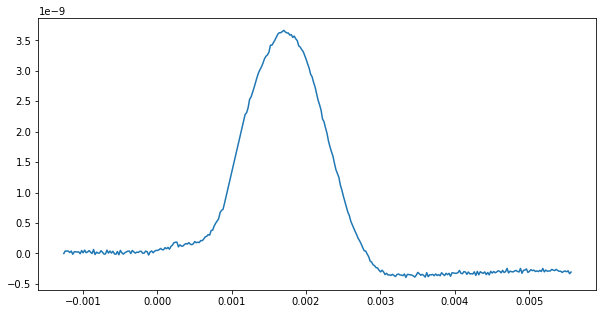

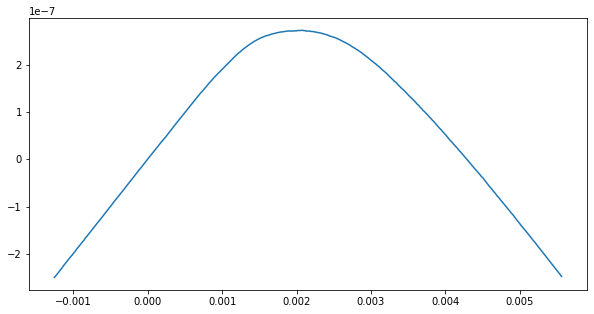

parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']


ValueError: operands could not be broadcast together with shapes (0,) (109,) 

In [17]:
# %%timeit
outdf = pd.DataFrame()
key = 'smoothed_indentation'
for curve_idx in n:
    outdf = run_analysis(file, curve_idx, outdf, key)
outdf.to_excel(f'./{key}.xlsx')